## Goal: test the reconstructed momentum operator Eq. (30) for different models

## Models:
1. critical Ising model (c=1/2): $\sum - Z - XX$
2. critical three-state Potts model (c=4/5): $\sum - Z_3 - Z_3^\dagger - X_3 X_3^\dagger - X_3^\dagger X_3$
3. XX model (c=1): $\sum XX + YY$
4. Heisenberg model (c=1): $\sum XX + YY + ZZ$

## Usage: test(model, L, n=20, rescale=True)
Plot the lowest $n$ eigenvalues of $i \log T$ and the reconstructed momentum of length $L$. 
If `rescale=True`, we rescale both operators by $\frac{L}{2 \pi}$, so that it is easier to compare with the conformal spin $s$. 
Recall $P_{rec} |\Delta, s \rangle \approx \frac{2\pi}{L} s |\Delta, s \rangle$.

In [1]:
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=np.inf)
import matplotlib.pyplot as plt
from utils import *

In [11]:
def state_to_P(psi):
  d = psi.shape[0]
  L = len(psi.shape)

  rho1 = density_matrix(psi, [0])
  rho2 = density_matrix(psi, [0,1])

  K1 = K(rho1)
  K2 = K(rho2)
  
  K21 = K2 - 0.5 * extend(K1, [0], [d, d]) - 0.5 * extend(K1, [1], [d, d])
  tmp = ncon([K21, K21], [[-5,-6,1,-3],[-4,1,-1,-2]])
  P_local = (tmp - np.transpose(tmp, [3,4,5,0,1,2]).conj()) / np.pi**2

  return 1j * cyclic_operator(P_local, L)

def gen_T(L, d=2):
  T = np.zeros([d]*(2*L), dtype=float)

  A = np.array(np.meshgrid(*[[0,1]]*L, indexing='ij')).reshape(L, -1)
  A = A.T
  for s in A:
    T[tuple(s) + tuple(np.roll(s, -1))] = 1
  return T

def test(model, L, n=20, rescale=True, xticks=None, yticks=None):
  H = gen_Hamiltonian(model, L)
  d = H.shape[0]
  psi = ground_state(H)
  P = state_to_P(psi)
  T = gen_T(L, d=d)

  eigvals, eigvecs = np.linalg.eigh((H + 1e-6 * P).reshape(d**L, d**L))
  P_eigvals = my_ncon([eigvecs[:, :n].T.conj(), P.reshape(d**L, d**L), eigvecs[:, :n]], [[-1, 2], [2, 3], [3, -1]])
  T_eigvals = my_ncon([eigvecs[:, :n].T.conj(), T.reshape(d**L, d**L), eigvecs[:, :n]], [[-1, 2], [2, 3], [3, -1]])

  plt.figure(figsize=(4,3))
  n = min(n, len(eigvals))
  X = np.arange(n)
  if rescale:
    plt.scatter(X, -np.angle(T_eigvals[:n]) * L / 2 / np.pi, s=50, marker='o', facecolors='none', edgecolors='r', label=r'$\frac{L}{2 \pi}$ $i$ $\log T$')
    plt.scatter(X, P_eigvals.real[:n] * L / 2 / np.pi, s=30, marker='x', c='b', label=r'$\frac{L}{2 \pi}$ $P$')
    plt.ylim(-L/2-0.1, L/2+0.1)
  else:
    plt.scatter(X, -np.angle(T_eigvals[:n]), s=50, marker='o', facecolors='none', edgecolors='r', label=r'$i$ $\log T$')
    plt.scatter(X, P_eigvals.real[:n], s=30, marker='x', c='b', label=r'$P$')
    plt.ylim(-L/2-0.1, L/2+0.1)
  plt.grid()
  plt.legend(loc='upper left')
  plt.xticks(xticks)
  plt.yticks(yticks)
  plt.tight_layout()

def test_mod_pi(model, L, rescale=True, n=20, xticks=None, yticks=None):
  '''Note that this simplification only woks when L is even for XX and Heisenberg'''

  H = gen_Hamiltonian(model, L)
  d = H.shape[0]
  psi = ground_state(H)
  P = state_to_P(psi)
  T = gen_T(L, d=d)

  eigvals, eigvecs = np.linalg.eigh((H + 1e-6 * P).reshape(d**L, d**L))
  P_eigvals = my_ncon([eigvecs[:, :n].T.conj(), P.reshape(d**L, d**L), eigvecs[:, :n]], [[-1, 2], [2, 3], [3, -1]])
  T_eigvals = my_ncon([eigvecs[:, :n].T.conj(), T.reshape(d**L, d**L), eigvecs[:, :n]], [[-1, 2], [2, 3], [3, -1]])

  def mod_pi(arr):
    '''Add or subtract by pi, so that the value is between -pi/2 and pi/2'''
    return np.where(arr > np.pi/2, arr-np.pi, np.where(arr < -np.pi/2, arr+np.pi, arr))

  plt.figure(figsize=(4,3))
  n = min(n, len(eigvals))
  X = np.arange(n)
  if rescale:
    plt.scatter(X, mod_pi(-np.angle(T_eigvals[:n])) * L / 2 / np.pi, s=50, marker='o', facecolors='none', edgecolors='r', label=r'$\frac{L}{2 \pi}$ ($i$ $\log T$ mod $\pi$)')
    plt.scatter(X, mod_pi(P_eigvals.real[:n]) * L / 2 / np.pi, s=30, marker='x', c='b', label=r'$\frac{L}{2 \pi}$ ($P$ mod $\pi$)')
    plt.ylim(-L/4-0.1, L/4+0.1)
  else:
    plt.scatter(X, mod_pi(-np.angle(T_eigvals[:n])), s=50, marker='o', facecolors='none', edgecolors='r', label=r'$i$ $\log T$ mod $\pi$')
    plt.scatter(X, mod_pi(P_eigvals.real[:n]), s=30, marker='x', c='b', label=r'$P$ mod $\pi$')
    plt.ylim(-L/4-0.1, L/4+0.1)
  plt.grid()
  plt.legend(loc='upper left')
  plt.xticks(xticks)
  plt.yticks(yticks)
  plt.tight_layout()

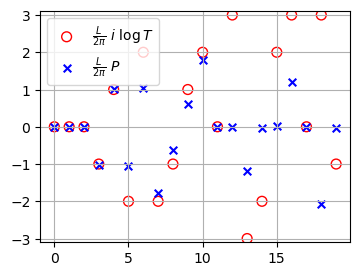

In [43]:
test('Ising', 6, n=20)

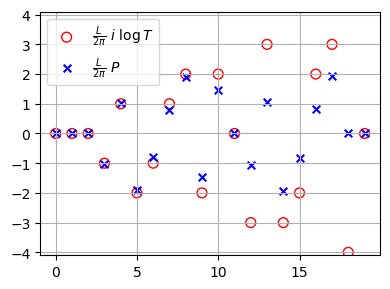

In [10]:
test('Ising', 8, n=20, yticks=[-4,-3,-2,-1,0,1,2,3,4])
# plt.savefig('reconstructed-P-Ising-L=8.pdf', dpi=300)

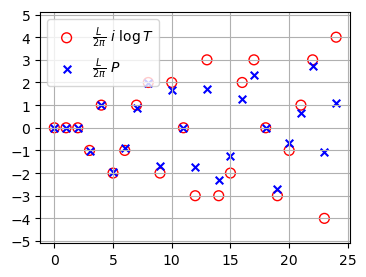

In [45]:
test('Ising', 10, n=25, yticks=[-5,-4,-3,-2,-1,0,1,2,3,4,5])
# plt.savefig('reconstructed-P-Ising-L=10.pdf', dpi=300)

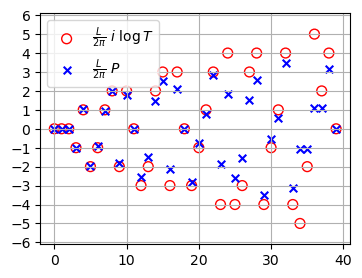

In [46]:
test('Ising', 12, n=40, yticks=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
# plt.savefig('reconstructed-P-Ising-L=12.pdf', dpi=300)

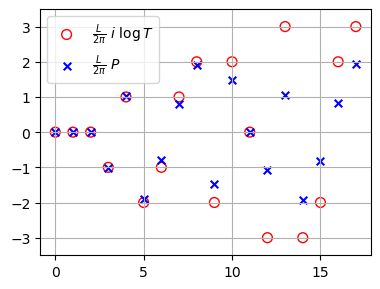

In [12]:
test('Ising', 8, n=18, yticks=[-3,-2,-1,0,1,2,3])
plt.ylim(-3-0.5, 3+0.5)
plt.tight_layout()
plt.savefig('reconstructed-P-Ising-L=8.pdf', dpi=300)

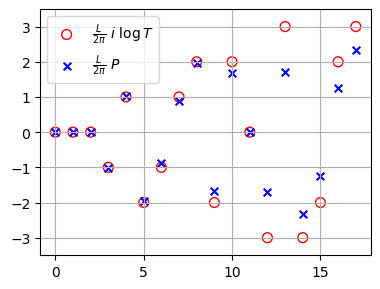

In [13]:
test('Ising', 10, n=18, yticks=[-3,-2,-1,0,1,2,3])
plt.ylim(-3-0.5, 3+0.5)
plt.tight_layout()
plt.savefig('reconstructed-P-Ising-L=10.pdf', dpi=300)

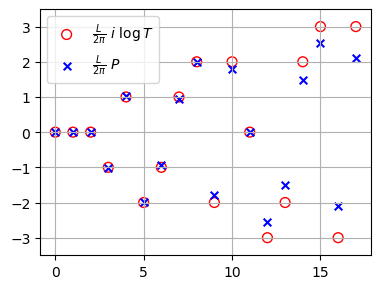

In [14]:
test('Ising', 12, n=18, yticks=[-3,-2,-1,0,1,2,3])
plt.ylim(-3-0.5, 3+0.5)
plt.tight_layout()
plt.savefig('reconstructed-P-Ising-L=12.pdf', dpi=300)

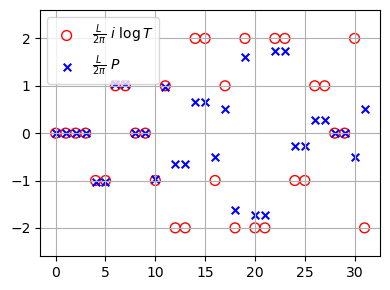

In [8]:
test('Potts', 5, n=32)

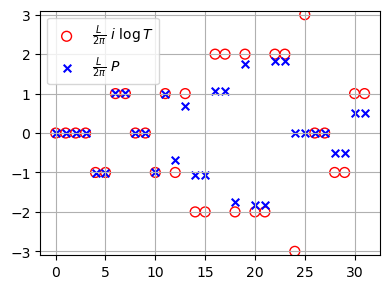

In [3]:
test('Potts', 6, n=32)
plt.savefig('reconstructed-P-Potts-L=6.pdf', dpi=300)

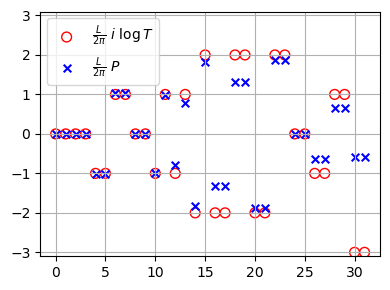

In [5]:
test('Potts', 7, n=32)
plt.ylim(-3-0.1, 3+0.1)
plt.tight_layout()
plt.savefig('reconstructed-P-Potts-L=7.pdf', dpi=300)

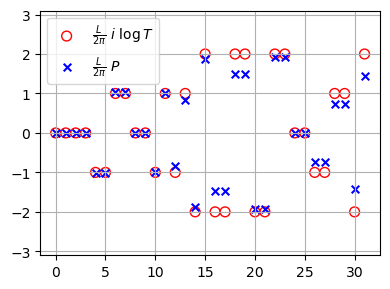

In [6]:
test('Potts', 8, n=32)
plt.ylim(-3-0.1, 3+0.1)
plt.tight_layout()
plt.savefig('reconstructed-P-Potts-L=8.pdf', dpi=300)

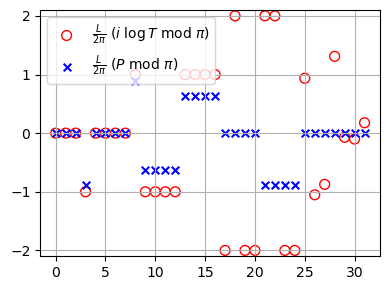

In [12]:
test_mod_pi('XX', 8, n=32, yticks=[-2,-1,0,1,2])

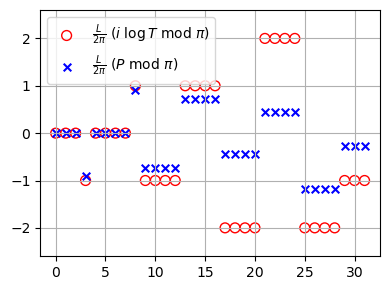

In [9]:
test_mod_pi('XX', 10, n=32, yticks=[-2,-1,0,1,2])

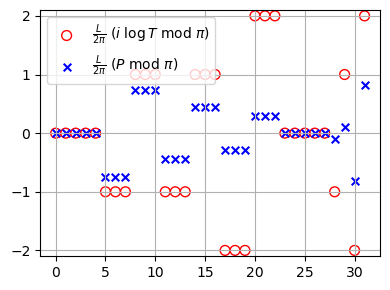

In [13]:
test_mod_pi('Heisenberg', 8, n=32, yticks=[-2,-1,0,1,2])
plt.savefig('reconstructed-P-Heisenberg-L=8.pdf', dpi=300)

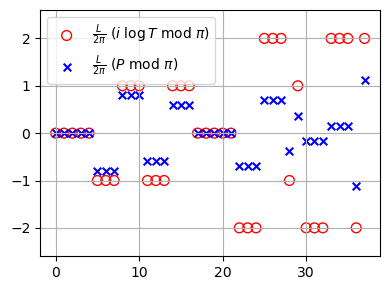

In [14]:
test_mod_pi('Heisenberg', 10, n=38, yticks=[-2,-1,0,1,2])
plt.savefig('reconstructed-P-Heisenberg-L=10.pdf', dpi=300)

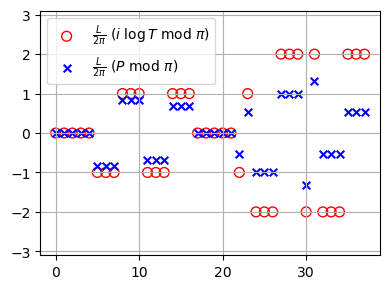

In [15]:
test_mod_pi('Heisenberg', 12, n=38, yticks=[-3,-2,-1,0,1,2,3])
plt.savefig('reconstructed-P-Heisenberg-L=12.pdf', dpi=300)